# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Sat Dec 26 14:53:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
| 19%   61C    P8    13W / 151W |    809MiB /  8192MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
# define plot function
def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="valid loss")
    plt.title("Training & Valid Loss")
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label="training acc")
    plt.plot(epochs, val_acc, label="valid acc")
    plt.title("Training & Valid Accuracy")
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history["precision"]
    val_precision = history.history["val_precision"]
    epochs = range(1, len(precision) + 1)
    plt.plot(epochs, precision, label="training precision")
    plt.plot(epochs, val_precision, label="valid precision")
    plt.title("Training & Valid Precision")
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]
    epochs = range(1, len(recall) + 1)
    plt.plot(epochs, recall, label="training recall")
    plt.plot(epochs, val_recall, label="valid recall")
    plt.title("Training & Valid Recall")
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history["auc"]
    val_auc = history.history["val_auc"]
    epochs = range(1, len(auc) + 1)
    plt.plot(epochs, auc, label="training auc")
    plt.plot(epochs, val_auc, label="valid auc")
    plt.title("Training & Valid AUC")
    plt.legend()
    plt.show()

# Prepare dataset & base model

- Split train & test
- Compute weight for each class
- Create Image generator
- Create model

In [5]:
!dir "D:/Datasets/thesis_dr/aptos2019/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019

12/26/2020  02:17 PM    <DIR>          .
12/26/2020  02:17 PM    <DIR>          ..
12/18/2019  03:27 AM            54,948 aptos_train.csv
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash - Copy.csv
12/26/2020  12:59 PM           702,068 df_train_dhash - Copy.xlsx
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
12/26/2020  02:19 PM    <DIR>          models
12/21/2020  07:33 AM    30,245,087,887 models.7z
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/17/2020  02:28 PM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/17/2020  02:28 PM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
12/19/2020  12:55 PM    <DIR>          train_images_300
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/26/2020  09:41 AM    <DIR>     

In [6]:
# define our working directory
dir_base = "D:/Datasets/thesis_dr/aptos2019/"
dir_img = os.path.join(dir_base, "train_images_300/train_images_rescaled_300")
dir_save = os.path.join(dir_base, "models/fine_tune_n_layer/")

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

id_code  diagnosis  is_exist  \
0     000c1434d8d7.png          2      True   
1     001639a390f0.png          4      True   
2     0024cdab0c1e.png          1      True   
3     002c21358ce6.png          0      True   
4     005b95c28852.png          0      True   
...                ...        ...       ...   
3657  ffa47f6a7bf4.png          2      True   
3658  ffc04fed30e6.png          0      True   
3659  ffcf7b45f213.png          2      True   
3660  ffd97f8cd5aa.png          0      True   
3661  ffec9a18a3ce.png          2      True   

                                                  dhash  freq keep  
0     4505549846649357848361897357201341356077337430...     1  yes  
1     2329637184878609198035515006640525134579216941...     1  yes  
2     2423240825355712633243422248054645083667877231...     1  yes  
3     6900833685078708622050523299339707984650415156...     1  yes  
4     1596672251484725956711788094558338750112176232...     1  yes  
...                                                 ...   ...  ...  
3657  1714415029888012417314661111083115996014360412...     1  yes  
3658  1596672252599988637907833311359172559898032526...     1  yes  
3659  2371174750225767638951270617106319090295289270...     1  yes  
3660  4495615386714830418073151623371454397778002504...     1  yes  
3661  8797082316593930222949141631319107819201625754...     1  yes  

[3662 rows x 6 columns]

In [8]:
df.groupby('diagnosis')[['id_code']].count()

id_code
diagnosis         
0             1805
1              370
2              999
3              193
4              295

In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

id_code diagnosis
0     000c1434d8d7.png         2
1     001639a390f0.png         4
2     0024cdab0c1e.png         1
3     002c21358ce6.png         0
4     005b95c28852.png         0
...                ...       ...
3493  ffa47f6a7bf4.png         2
3494  ffc04fed30e6.png         0
3495  ffcf7b45f213.png         2
3496  ffd97f8cd5aa.png         0
3497  ffec9a18a3ce.png         2

[3498 rows x 2 columns]

In [10]:
df.groupby('diagnosis').count()

id_code
diagnosis         
0             1796
1              338
2              921
3              173
4              270

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

id_code
diagnosis         
0             1437
1              271
2              736
3              138
4              216

In [13]:
df_valid.groupby('diagnosis').count()

id_code
diagnosis         
0              359
1               67
2              185
3               35
4               54

In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

In [17]:
image_shape = (299, 299, 3)
batch_size = 32

In [18]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [19]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

In [20]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [21]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(dir_save, "log_training.csv"), separator=",", append=True)]

# Check training dataset

In [22]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [23]:
df_valid.head(3)

id_code diagnosis
2   0024cdab0c1e.png         1
12  00f6c1be5a33.png         0
18  0151781fe50b.png         0

In [24]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [25]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [26]:
fname = train_generator.filenames[image_idx]
fname

'83038ca49b6d.png'

In [27]:
df.loc[df["id_code"] == fname]

id_code diagnosis
1797  83038ca49b6d.png         0

In [28]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

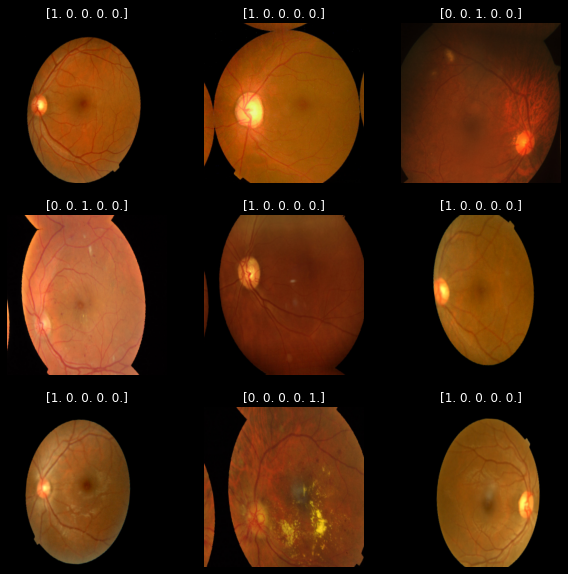

In [29]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis("off")

plt.show

# Load weights from trained classifier

In [30]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [31]:
conv_base, model = create_model()

In [32]:
utils.plot_model(conv_base, show_layer_names=True, show_shapes=True)

In [33]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

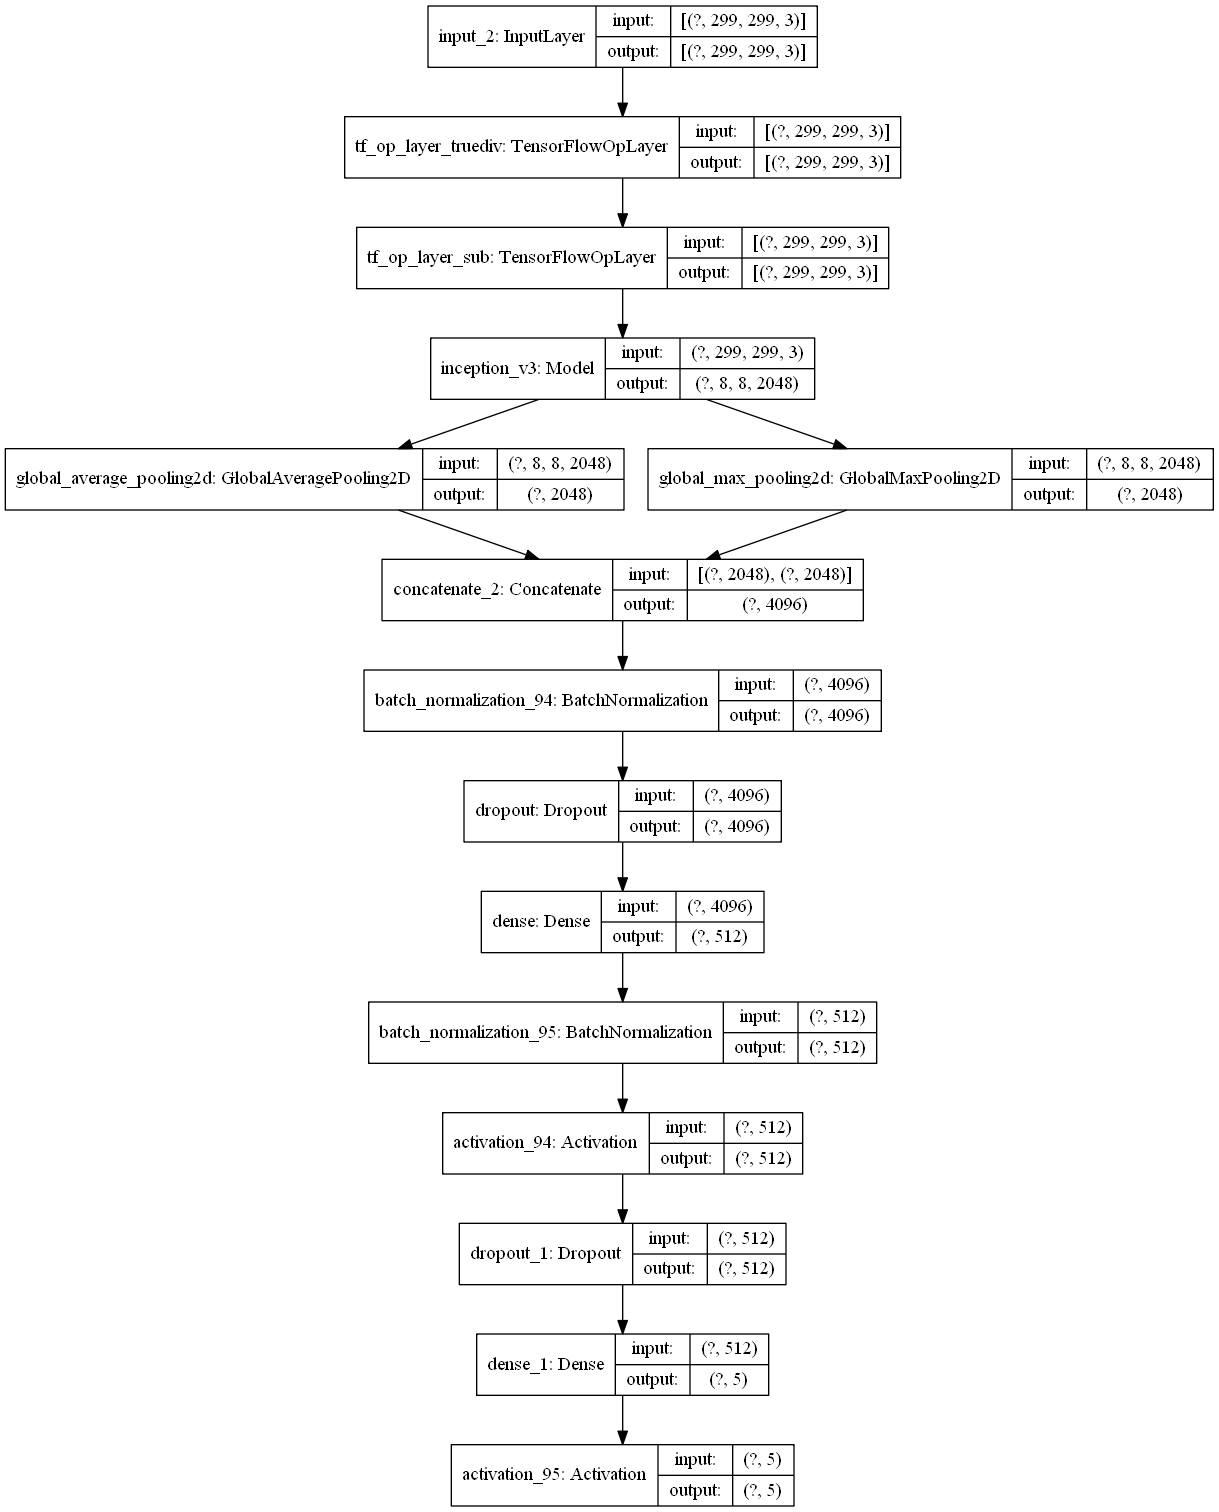

In [34]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [35]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 18s 823ms/step - loss: 12.0365 - categorical_accuracy: 0.4714 - precision: 0.4707 - recall: 0.4357 - auc: 0.6207


[12.036452380093662, 0.47142857, 0.47067901, 0.43571427, 0.62070644]

In [36]:
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [38]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 11s 500ms/step - loss: 1.9498 - categorical_accuracy: 0.7386 - precision: 0.8078 - recall: 0.6786 - auc: 0.9421


[1.9497523687102578, 0.7385714, 0.8078231, 0.6785714, 0.9420989]

# Fine Tune N=1

In [39]:
del(model)

In [40]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [41]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed9":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [42]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_3 False
conv2d_94 False
batch_normalization_96 False
activation_96 False
conv2d_95 False
batch_normalization_97 False
activation_97 False
conv2d_96 False
batch_normalization_98 False
activation_98 False
max_pooling2d_4 False
conv2d_97 False
batch_normalization_99 False
activation_99 False
conv2d_98 False
batch_normalization_100 False
activation_100 False
max_pooling2d_5 False
conv2d_102 False
batch_normalization_104 False
activation_104 False
conv2d_100 False
conv2d_103 False
batch_normalization_102 False
batch_normalization_105 False
activation_102 False
activation_105 False
average_pooling2d_9 False
conv2d_99 False
conv2d_101 False
conv2d_104 False
conv2d_105 False
batch_normalization_101 False
batch_normalization_103 False
batch_normalization_106 False
batch_normalization_107 False
activation_101 False
activation_103 False
activation_106 False
activation_107 False
mixed0 False
conv2d_109 False
batch_normalization_111 False
activation_111 False
conv2d_107 False
conv2d_110 False

In [43]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [44]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 252s 3s/step - loss: 1.9598 - categorical_accuracy: 0.7813 - precision: 0.8265 - recall: 0.7234 - auc: 0.9586 - val_loss: 2.3591 - val_categorical_accuracy: 0.7400 - val_precision: 0.8030 - val_recall: 0.6814 - val_auc: 0.9431
Epoch 2/50
88/88 [==============================] - 170s 2s/step - loss: 1.9385 - categorical_accuracy: 0.7791 - precision: 0.8331 - recall: 0.7259 - auc: 0.9600 - val_loss: 2.3547 - val_categorical_accuracy: 0.7443 - val_precision: 0.8041 - val_recall: 0.6800 - val_auc: 0.9439
Epoch 3/50
88/88 [==============================] - 164s 2s/step - loss: 1.9367 - categorical_accuracy: 0.7831 - precision: 0.8418 - recall: 0.7266 - auc: 0.9615 - val_loss: 2.3479 - val_categorical_accuracy: 0.7429 - val_precision: 0.8013 - val_recall: 0.6800 - val_auc: 0.9435
Epoch 4/50
88/88 [==============================] - 160s 2s/step - loss

In [45]:
model.save(os.path.join(dir_save, "fine_tune-1_layer.h5"))

## Plot training result

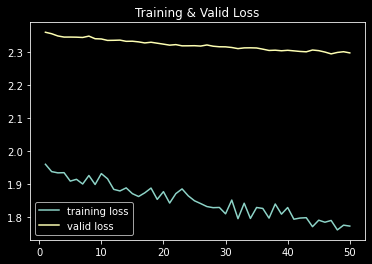

In [46]:
plot_loss(history)

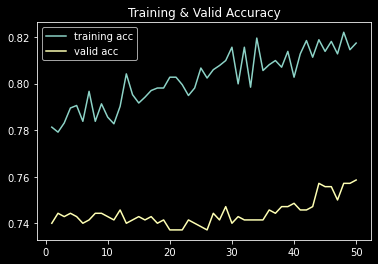

In [47]:
plot_acc(history)

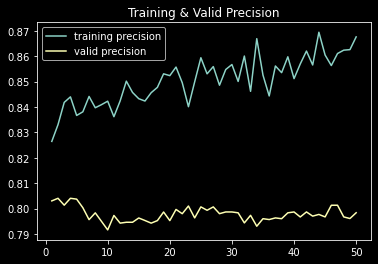

In [48]:
plot_precision(history)

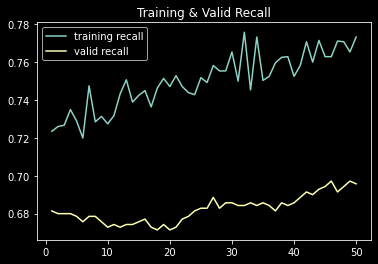

In [49]:
plot_recall(history)

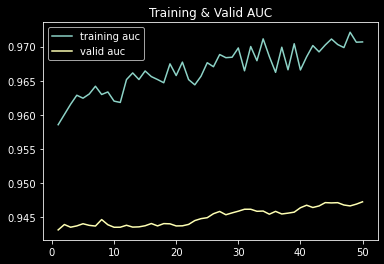

In [50]:
plot_auc(history)

## Evaluate model

In [51]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 693ms/step - loss: 1.8637 - categorical_accuracy: 0.7586 - precision: 0.7984 - recall: 0.6957 - auc: 0.9473


[1.8637107556516475, 0.75857145, 0.79836065, 0.6957143, 0.9472505]

In [52]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [53]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 592ms/step


In [54]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.96      0.95       359
         mild       0.49      0.50      0.49        68
     moderate       0.67      0.64      0.66       184
       severe       0.32      0.43      0.37        35
proliferative       0.45      0.39      0.42        54

     accuracy                           0.76       700
    macro avg       0.57      0.58      0.58       700
 weighted avg       0.76      0.76      0.76       700



In [55]:
confusion_matrix(y_true, y_pred)

array([[343,   9,   7,   0,   0],
       [  7,  34,  23,   2,   2],
       [  7,  20, 118,  23,  16],
       [  1,   1,  10,  15,   8],
       [  2,   6,  18,   7,  21]], dtype=int64)

# Fine Tune N=2

In [56]:
del(model)

In [57]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [58]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed8":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [59]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_5 False
conv2d_188 False
batch_normalization_192 False
activation_192 False
conv2d_189 False
batch_normalization_193 False
activation_193 False
conv2d_190 False
batch_normalization_194 False
activation_194 False
max_pooling2d_8 False
conv2d_191 False
batch_normalization_195 False
activation_195 False
conv2d_192 False
batch_normalization_196 False
activation_196 False
max_pooling2d_9 False
conv2d_196 False
batch_normalization_200 False
activation_200 False
conv2d_194 False
conv2d_197 False
batch_normalization_198 False
batch_normalization_201 False
activation_198 False
activation_201 False
average_pooling2d_18 False
conv2d_193 False
conv2d_195 False
conv2d_198 False
conv2d_199 False
batch_normalization_197 False
batch_normalization_199 False
batch_normalization_202 False
batch_normalization_203 False
activation_197 False
activation_199 False
activation_202 False
activation_203 False
mixed0 False
conv2d_203 False
batch_normalization_207 False
activation_207 False
conv2d_201 False
c

In [60]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [61]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 156s 2s/step - loss: 1.9279 - categorical_accuracy: 0.7791 - precision: 0.8244 - recall: 0.7166 - auc: 0.9595 - val_loss: 2.3487 - val_categorical_accuracy: 0.7400 - val_precision: 0.8017 - val_recall: 0.6814 - val_auc: 0.9429
Epoch 2/50
88/88 [==============================] - 141s 2s/step - loss: 1.9246 - categorical_accuracy: 0.7841 - precision: 0.8462 - recall: 0.7273 - auc: 0.9622 - val_loss: 2.3455 - val_categorical_accuracy: 0.7371 - val_precision: 0.7993 - val_recall: 0.6829 - val_auc: 0.9434
Epoch 3/50
88/88 [==============================] - 140s 2s/step - loss: 1.9079 - categorical_accuracy: 0.7916 - precision: 0.8419 - recall: 0.7405 - auc: 0.9627 - val_loss: 2.3414 - val_categorical_accuracy: 0.7386 - val_precision: 0.8034 - val_recall: 0.6829 - val_auc: 0.9432
Epoch 4/50
88/88 [==============================] - 141s 2s/step - loss

In [62]:
model.save(os.path.join(dir_save, "fine_tune-2_layer.h5"))

## Plot training result

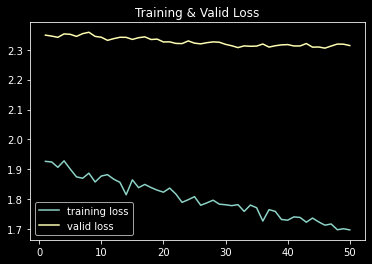

In [63]:
plot_loss(history)

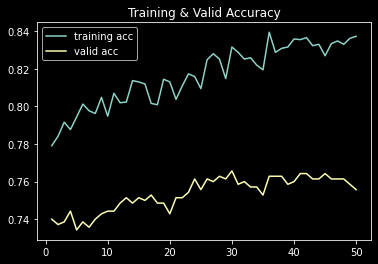

In [64]:
plot_acc(history)

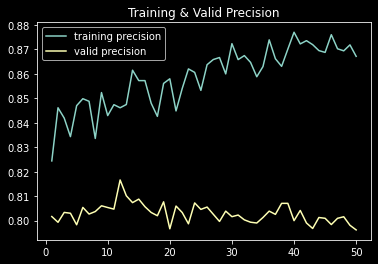

In [65]:
plot_precision(history)

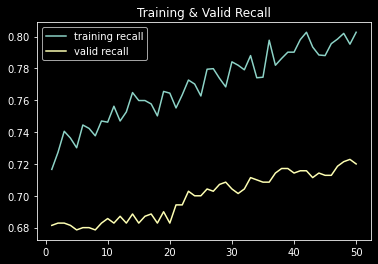

In [66]:
plot_recall(history)

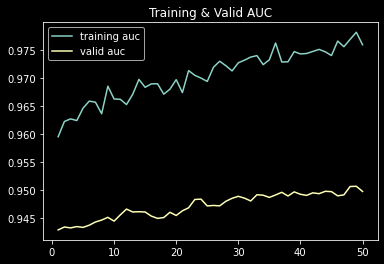

In [67]:
plot_auc(history)

## Evaluate model

In [68]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 16s 737ms/step - loss: 1.8552 - categorical_accuracy: 0.7557 - precision: 0.7962 - recall: 0.7200 - auc: 0.9497


[1.8551516045223584, 0.7557143, 0.79620856, 0.72, 0.94972295]

In [69]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [70]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 595ms/step


In [71]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       359
         mild       0.47      0.50      0.49        68
     moderate       0.66      0.62      0.64       184
       severe       0.37      0.40      0.38        35
proliferative       0.39      0.41      0.40        54

     accuracy                           0.76       700
    macro avg       0.57      0.58      0.57       700
 weighted avg       0.76      0.76      0.76       700



In [72]:
confusion_matrix(y_true, y_pred)

array([[344,   7,   8,   0,   0],
       [  7,  34,  23,   1,   3],
       [  7,  24, 115,  17,  21],
       [  0,   1,  10,  14,  10],
       [  2,   6,  18,   6,  22]], dtype=int64)

# Fine Tune N=3

In [73]:
del(model)

In [74]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [75]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed7":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [76]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_7 False
conv2d_282 False
batch_normalization_288 False
activation_288 False
conv2d_283 False
batch_normalization_289 False
activation_289 False
conv2d_284 False
batch_normalization_290 False
activation_290 False
max_pooling2d_12 False
conv2d_285 False
batch_normalization_291 False
activation_291 False
conv2d_286 False
batch_normalization_292 False
activation_292 False
max_pooling2d_13 False
conv2d_290 False
batch_normalization_296 False
activation_296 False
conv2d_288 False
conv2d_291 False
batch_normalization_294 False
batch_normalization_297 False
activation_294 False
activation_297 False
average_pooling2d_27 False
conv2d_287 False
conv2d_289 False
conv2d_292 False
conv2d_293 False
batch_normalization_293 False
batch_normalization_295 False
batch_normalization_298 False
batch_normalization_299 False
activation_293 False
activation_295 False
activation_298 False
activation_299 False
mixed0 False
conv2d_297 False
batch_normalization_303 False
activation_303 False
conv2d_295 False

In [77]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [78]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 165s 2s/step - loss: 1.9585 - categorical_accuracy: 0.7727 - precision: 0.8293 - recall: 0.7187 - auc: 0.9584 - val_loss: 2.3553 - val_categorical_accuracy: 0.7357 - val_precision: 0.8000 - val_recall: 0.6800 - val_auc: 0.9421
Epoch 2/50
88/88 [==============================] - 141s 2s/step - loss: 1.9338 - categorical_accuracy: 0.7873 - precision: 0.8299 - recall: 0.7305 - auc: 0.9609 - val_loss: 2.3526 - val_categorical_accuracy: 0.7443 - val_precision: 0.7970 - val_recall: 0.6729 - val_auc: 0.9428
Epoch 3/50
88/88 [==============================] - 141s 2s/step - loss: 1.9171 - categorical_accuracy: 0.7938 - precision: 0.8430 - recall: 0.7370 - auc: 0.9632 - val_loss: 2.3496 - val_categorical_accuracy: 0.7457 - val_precision: 0.7986 - val_recall: 0.6743 - val_auc: 0.9436
Epoch 4/50
88/88 [==============================] - 141s 2s/step - loss

In [79]:
model.save(os.path.join(dir_save, "fine_tune-3_layer.h5"))

## Plot training result

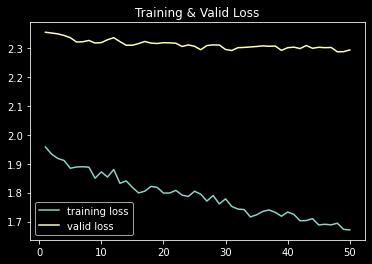

In [80]:
plot_loss(history)

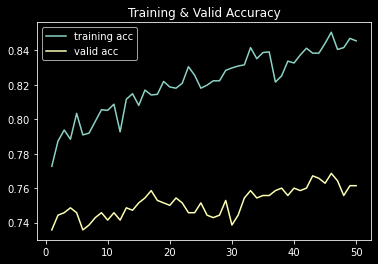

In [81]:
plot_acc(history)

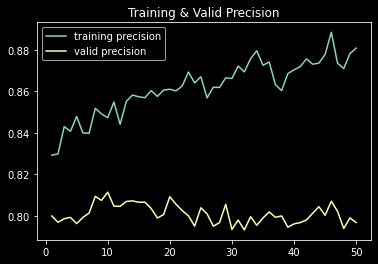

In [82]:
plot_precision(history)

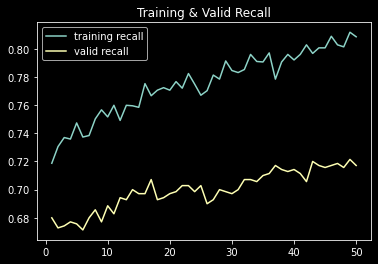

In [83]:
plot_recall(history)

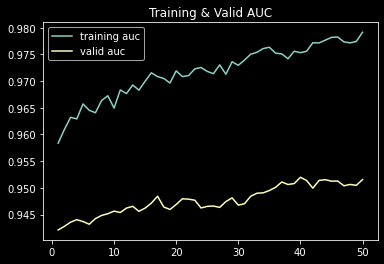

In [84]:
plot_auc(history)

## Evaluate model

In [85]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 652ms/step - loss: 1.8412 - categorical_accuracy: 0.7614 - precision: 0.7968 - recall: 0.7171 - auc: 0.9516


[1.841193600134416, 0.7614286, 0.7968254, 0.7171429, 0.951555]

In [86]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [87]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 602ms/step


In [88]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       359
         mild       0.45      0.47      0.46        68
     moderate       0.68      0.65      0.66       184
       severe       0.37      0.43      0.39        35
proliferative       0.44      0.44      0.44        54

     accuracy                           0.76       700
    macro avg       0.58      0.59      0.58       700
 weighted avg       0.77      0.76      0.76       700



In [89]:
confusion_matrix(y_true, y_pred)

array([[343,   8,   8,   0,   0],
       [  8,  32,  22,   3,   3],
       [  5,  24, 119,  18,  18],
       [  0,   1,   9,  15,  10],
       [  1,   6,  18,   5,  24]], dtype=int64)

# Fine Tune N=4

In [90]:
del(model)

In [91]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [92]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed6":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [93]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_9 False
conv2d_376 False
batch_normalization_384 False
activation_384 False
conv2d_377 False
batch_normalization_385 False
activation_385 False
conv2d_378 False
batch_normalization_386 False
activation_386 False
max_pooling2d_16 False
conv2d_379 False
batch_normalization_387 False
activation_387 False
conv2d_380 False
batch_normalization_388 False
activation_388 False
max_pooling2d_17 False
conv2d_384 False
batch_normalization_392 False
activation_392 False
conv2d_382 False
conv2d_385 False
batch_normalization_390 False
batch_normalization_393 False
activation_390 False
activation_393 False
average_pooling2d_36 False
conv2d_381 False
conv2d_383 False
conv2d_386 False
conv2d_387 False
batch_normalization_389 False
batch_normalization_391 False
batch_normalization_394 False
batch_normalization_395 False
activation_389 False
activation_391 False
activation_394 False
activation_395 False
mixed0 False
conv2d_391 False
batch_normalization_399 False
activation_399 False
conv2d_389 False

In [94]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [95]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 161s 2s/step - loss: 1.9451 - categorical_accuracy: 0.7859 - precision: 0.8436 - recall: 0.7230 - auc: 0.9613 - val_loss: 2.3587 - val_categorical_accuracy: 0.7486 - val_precision: 0.8071 - val_recall: 0.6814 - val_auc: 0.9447
Epoch 2/50
88/88 [==============================] - 141s 2s/step - loss: 1.9416 - categorical_accuracy: 0.7856 - precision: 0.8374 - recall: 0.7252 - auc: 0.9596 - val_loss: 2.3572 - val_categorical_accuracy: 0.7429 - val_precision: 0.8027 - val_recall: 0.6800 - val_auc: 0.9455
Epoch 3/50
88/88 [==============================] - 141s 2s/step - loss: 1.8954 - categorical_accuracy: 0.7974 - precision: 0.8413 - recall: 0.7445 - auc: 0.9642 - val_loss: 2.3453 - val_categorical_accuracy: 0.7514 - val_precision: 0.8041 - val_recall: 0.6800 - val_auc: 0.9460
Epoch 4/50
88/88 [==============================] - 140s 2s/step - loss

In [96]:
model.save(os.path.join(dir_save, "fine_tune-4_layer.h5"))

## Plot training result

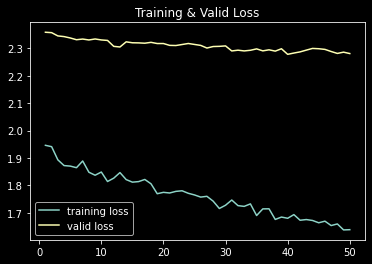

In [97]:
plot_loss(history)

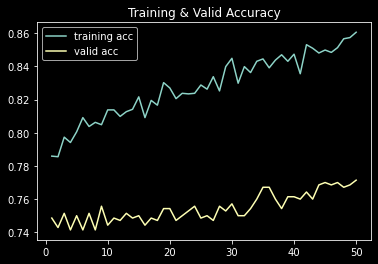

In [98]:
plot_acc(history)

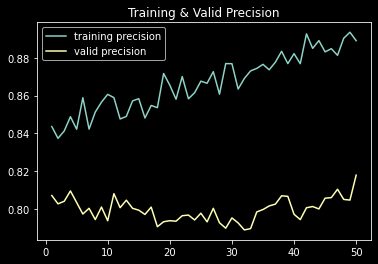

In [99]:
plot_precision(history)

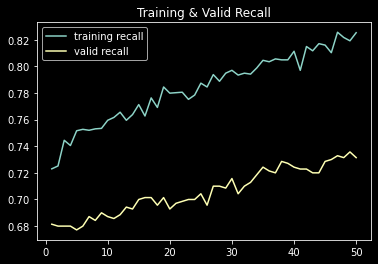

In [100]:
plot_recall(history)

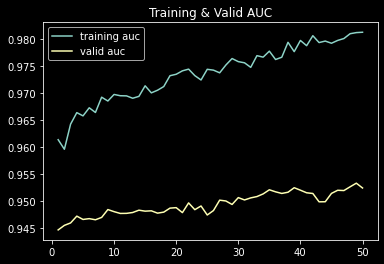

In [101]:
plot_auc(history)

## Evaluate model

In [102]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 655ms/step - loss: 1.8365 - categorical_accuracy: 0.7714 - precision: 0.8179 - recall: 0.7314 - auc: 0.9524


[1.8364710753614253, 0.7714286, 0.81789136, 0.73142856, 0.9524271]

In [103]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [104]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 604ms/step


In [105]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       359
         mild       0.51      0.53      0.52        68
     moderate       0.68      0.66      0.67       184
       severe       0.39      0.46      0.42        35
proliferative       0.45      0.43      0.44        54

     accuracy                           0.77       700
    macro avg       0.60      0.61      0.60       700
 weighted avg       0.77      0.77      0.77       700



In [106]:
confusion_matrix(y_true, y_pred)

array([[343,   8,   8,   0,   0],
       [  6,  36,  21,   1,   4],
       [  8,  18, 122,  19,  17],
       [  0,   2,  10,  16,   7],
       [  2,   6,  18,   5,  23]], dtype=int64)

# Fine Tune N=5

In [107]:
del(model)

In [108]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [109]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed5":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [110]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_11 False
conv2d_470 False
batch_normalization_480 False
activation_480 False
conv2d_471 False
batch_normalization_481 False
activation_481 False
conv2d_472 False
batch_normalization_482 False
activation_482 False
max_pooling2d_20 False
conv2d_473 False
batch_normalization_483 False
activation_483 False
conv2d_474 False
batch_normalization_484 False
activation_484 False
max_pooling2d_21 False
conv2d_478 False
batch_normalization_488 False
activation_488 False
conv2d_476 False
conv2d_479 False
batch_normalization_486 False
batch_normalization_489 False
activation_486 False
activation_489 False
average_pooling2d_45 False
conv2d_475 False
conv2d_477 False
conv2d_480 False
conv2d_481 False
batch_normalization_485 False
batch_normalization_487 False
batch_normalization_490 False
batch_normalization_491 False
activation_485 False
activation_487 False
activation_490 False
activation_491 False
mixed0 False
conv2d_485 False
batch_normalization_495 False
activation_495 False
conv2d_483 Fals

In [111]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_5 (TensorFl [(None, 299, 299, 3) 0           input_12[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_5 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_5[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_5[0][0]          
____________________________________________________________________________________________

In [112]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 191s 2s/step - loss: 1.9198 - categorical_accuracy: 0.7831 - precision: 0.8473 - recall: 0.7298 - auc: 0.9626 - val_loss: 2.3525 - val_categorical_accuracy: 0.7486 - val_precision: 0.8061 - val_recall: 0.6829 - val_auc: 0.9445
Epoch 2/50
88/88 [==============================] - 142s 2s/step - loss: 1.9224 - categorical_accuracy: 0.7898 - precision: 0.8421 - recall: 0.7355 - auc: 0.9622 - val_loss: 2.3410 - val_categorical_accuracy: 0.7429 - val_precision: 0.8037 - val_recall: 0.6786 - val_auc: 0.9450
Epoch 3/50
88/88 [==============================] - 141s 2s/step - loss: 1.9198 - categorical_accuracy: 0.7852 - precision: 0.8349 - recall: 0.7302 - auc: 0.9637 - val_loss: 2.3537 - val_categorical_accuracy: 0.7386 - val_precision: 0.7966 - val_recall: 0.6771 - val_auc: 0.9442
Epoch 4/50
88/88 [==============================] - 141s 2s/step - loss

In [113]:
model.save(os.path.join(dir_save, "fine_tune-5_layer.h5"))

## Plot training result

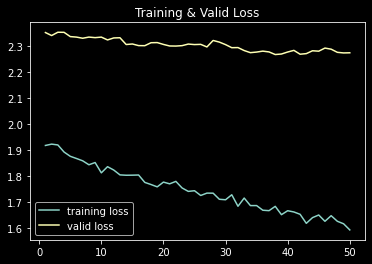

In [114]:
plot_loss(history)

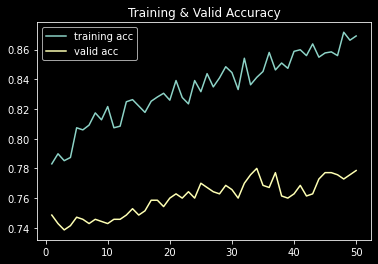

In [115]:
plot_acc(history)

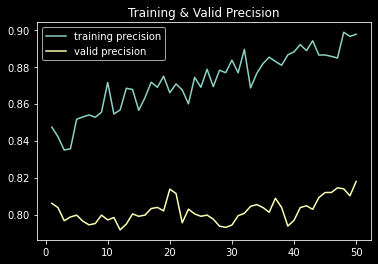

In [116]:
plot_precision(history)

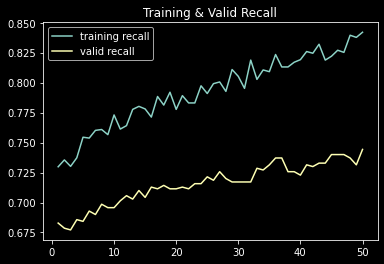

In [117]:
plot_recall(history)

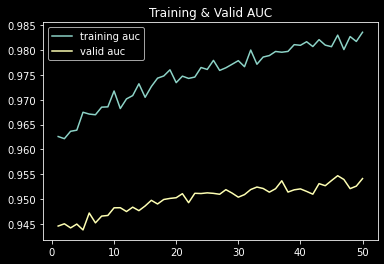

In [118]:
plot_auc(history)

## Evaluate model

In [119]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 663ms/step - loss: 1.8227 - categorical_accuracy: 0.7786 - precision: 0.8179 - recall: 0.7443 - auc: 0.9541


[1.822683578187769, 0.7785714, 0.81789637, 0.7442857, 0.9541087]

In [120]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [121]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 602ms/step


In [122]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       359
         mild       0.47      0.53      0.50        68
     moderate       0.70      0.66      0.68       184
       severe       0.41      0.37      0.39        35
proliferative       0.49      0.52      0.50        54

     accuracy                           0.78       700
    macro avg       0.61      0.61      0.61       700
 weighted avg       0.78      0.78      0.78       700



In [123]:
confusion_matrix(y_true, y_pred)

array([[346,   8,   5,   0,   0],
       [  7,  36,  22,   1,   2],
       [  6,  25, 122,  15,  16],
       [  0,   2,   9,  13,  11],
       [  1,   6,  16,   3,  28]], dtype=int64)

# Fine Tune N=6

In [124]:
del(model)

In [125]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [126]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed4":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [127]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_13 False
conv2d_564 False
batch_normalization_576 False
activation_576 False
conv2d_565 False
batch_normalization_577 False
activation_577 False
conv2d_566 False
batch_normalization_578 False
activation_578 False
max_pooling2d_24 False
conv2d_567 False
batch_normalization_579 False
activation_579 False
conv2d_568 False
batch_normalization_580 False
activation_580 False
max_pooling2d_25 False
conv2d_572 False
batch_normalization_584 False
activation_584 False
conv2d_570 False
conv2d_573 False
batch_normalization_582 False
batch_normalization_585 False
activation_582 False
activation_585 False
average_pooling2d_54 False
conv2d_569 False
conv2d_571 False
conv2d_574 False
conv2d_575 False
batch_normalization_581 False
batch_normalization_583 False
batch_normalization_586 False
batch_normalization_587 False
activation_581 False
activation_583 False
activation_586 False
activation_587 False
mixed0 False
conv2d_579 False
batch_normalization_591 False
activation_591 False
conv2d_577 Fals

In [128]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_6 (TensorFl [(None, 299, 299, 3) 0           input_14[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_6 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_6[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_6[0][0]          
____________________________________________________________________________________________

In [129]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 197s 2s/step - loss: 1.9446 - categorical_accuracy: 0.7709 - precision: 0.8274 - recall: 0.7177 - auc: 0.9591 - val_loss: 2.3774 - val_categorical_accuracy: 0.7429 - val_precision: 0.8041 - val_recall: 0.6800 - val_auc: 0.9451
Epoch 2/50
88/88 [==============================] - 160s 2s/step - loss: 1.9108 - categorical_accuracy: 0.7838 - precision: 0.8333 - recall: 0.7269 - auc: 0.9624 - val_loss: 2.3461 - val_categorical_accuracy: 0.7357 - val_precision: 0.7937 - val_recall: 0.6814 - val_auc: 0.9426
Epoch 3/50
88/88 [==============================] - 162s 2s/step - loss: 1.9031 - categorical_accuracy: 0.7909 - precision: 0.8422 - recall: 0.7437 - auc: 0.9653 - val_loss: 2.3272 - val_categorical_accuracy: 0.7286 - val_precision: 0.7936 - val_recall: 0.6700 - val_auc: 0.9412
Epoch 4/50
88/88 [==============================] - 160s 2s/step - loss

In [130]:
model.save(os.path.join(dir_save, "fine_tune-6_layer.h5"))

## Plot training result

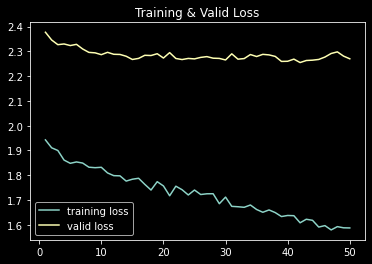

In [131]:
plot_loss(history)

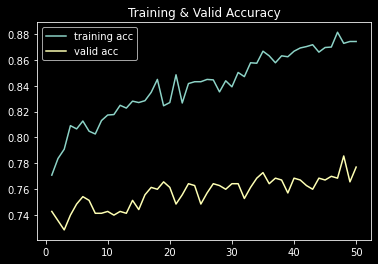

In [132]:
plot_acc(history)

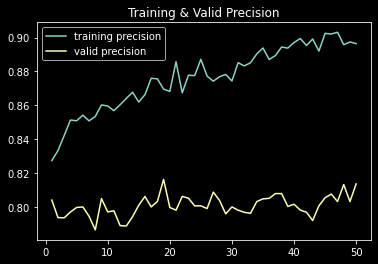

In [133]:
plot_precision(history)

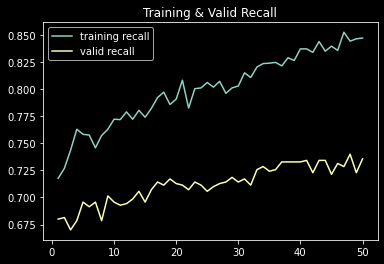

In [134]:
plot_recall(history)

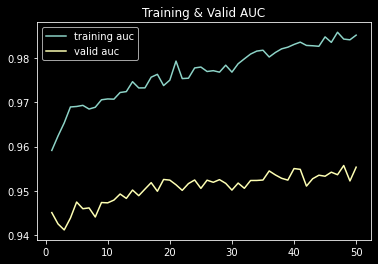

In [135]:
plot_auc(history)

## Evaluate model

In [136]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 663ms/step - loss: 1.8174 - categorical_accuracy: 0.7771 - precision: 0.8136 - recall: 0.7357 - auc: 0.9553


[1.8173673694783992, 0.7771429, 0.8135861, 0.73571426, 0.9553454]

In [137]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [138]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 605ms/step


In [139]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.52      0.59      0.55        68
     moderate       0.71      0.64      0.67       184
       severe       0.37      0.37      0.37        35
proliferative       0.46      0.48      0.47        54

     accuracy                           0.78       700
    macro avg       0.60      0.61      0.60       700
 weighted avg       0.78      0.78      0.78       700



In [140]:
confusion_matrix(y_true, y_pred)

array([[348,   7,   4,   0,   0],
       [  8,  40,  16,   2,   2],
       [ 10,  22, 117,  17,  18],
       [  0,   2,   9,  13,  11],
       [  1,   6,  18,   3,  26]], dtype=int64)

# Fine Tune N=7

In [141]:
del(model)

In [142]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [143]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed3":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [144]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_15 False
conv2d_658 False
batch_normalization_672 False
activation_672 False
conv2d_659 False
batch_normalization_673 False
activation_673 False
conv2d_660 False
batch_normalization_674 False
activation_674 False
max_pooling2d_28 False
conv2d_661 False
batch_normalization_675 False
activation_675 False
conv2d_662 False
batch_normalization_676 False
activation_676 False
max_pooling2d_29 False
conv2d_666 False
batch_normalization_680 False
activation_680 False
conv2d_664 False
conv2d_667 False
batch_normalization_678 False
batch_normalization_681 False
activation_678 False
activation_681 False
average_pooling2d_63 False
conv2d_663 False
conv2d_665 False
conv2d_668 False
conv2d_669 False
batch_normalization_677 False
batch_normalization_679 False
batch_normalization_682 False
batch_normalization_683 False
activation_677 False
activation_679 False
activation_682 False
activation_683 False
mixed0 False
conv2d_673 False
batch_normalization_687 False
activation_687 False
conv2d_671 Fals

In [145]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_7 (TensorFl [(None, 299, 299, 3) 0           input_16[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_7 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_7[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_7[0][0]          
____________________________________________________________________________________________

In [146]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 159s 2s/step - loss: 1.9357 - categorical_accuracy: 0.7802 - precision: 0.8298 - recall: 0.7248 - auc: 0.9607 - val_loss: 2.3453 - val_categorical_accuracy: 0.7271 - val_precision: 0.7872 - val_recall: 0.6657 - val_auc: 0.9388
Epoch 2/50
88/88 [==============================] - 141s 2s/step - loss: 1.9074 - categorical_accuracy: 0.7902 - precision: 0.8387 - recall: 0.7341 - auc: 0.9614 - val_loss: 2.3431 - val_categorical_accuracy: 0.7157 - val_precision: 0.7838 - val_recall: 0.6629 - val_auc: 0.9375
Epoch 3/50
88/88 [==============================] - 140s 2s/step - loss: 1.9143 - categorical_accuracy: 0.7906 - precision: 0.8427 - recall: 0.7448 - auc: 0.9638 - val_loss: 2.3468 - val_categorical_accuracy: 0.7443 - val_precision: 0.8007 - val_recall: 0.6886 - val_auc: 0.9445
Epoch 4/50
88/88 [==============================] - 141s 2s/step - loss

In [147]:
model.save(os.path.join(dir_save, "fine_tune-7_layer.h5"))

## Plot training result

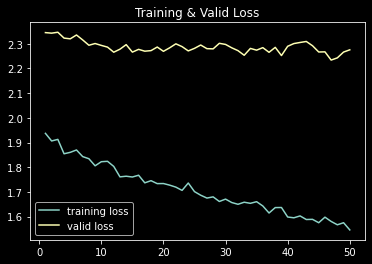

In [148]:
plot_loss(history)

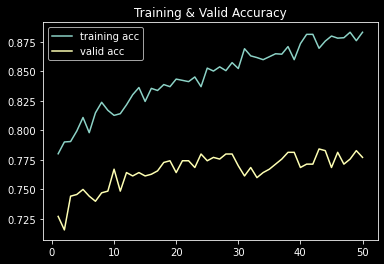

In [149]:
plot_acc(history)

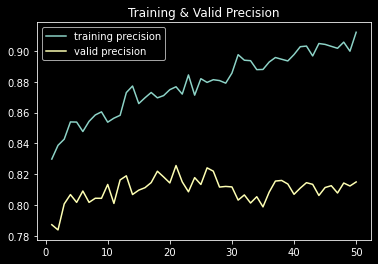

In [150]:
plot_precision(history)

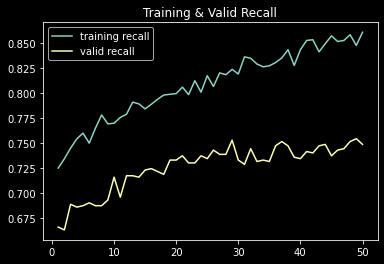

In [151]:
plot_recall(history)

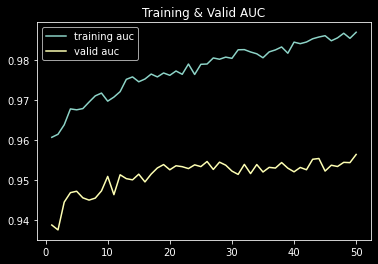

In [152]:
plot_auc(history)

## Evaluate model

In [153]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 675ms/step - loss: 1.8051 - categorical_accuracy: 0.7771 - precision: 0.8149 - recall: 0.7486 - auc: 0.9564


[1.8051033778624102, 0.7771429, 0.81493, 0.74857146, 0.9563788]

In [154]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [155]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 602ms/step


In [156]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.51      0.53      0.52        68
     moderate       0.70      0.66      0.68       184
       severe       0.37      0.43      0.39        35
proliferative       0.50      0.46      0.48        54

     accuracy                           0.78       700
    macro avg       0.61      0.61      0.61       700
 weighted avg       0.78      0.78      0.78       700



In [157]:
confusion_matrix(y_true, y_pred)

array([[347,   8,   4,   0,   0],
       [ 10,  36,  17,   1,   4],
       [  8,  20, 121,  20,  15],
       [  0,   2,  12,  15,   6],
       [  2,   4,  18,   5,  25]], dtype=int64)

# Fine Tune N=8

In [158]:
del(model)

In [159]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [160]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed2":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [161]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_17 False
conv2d_752 False
batch_normalization_768 False
activation_768 False
conv2d_753 False
batch_normalization_769 False
activation_769 False
conv2d_754 False
batch_normalization_770 False
activation_770 False
max_pooling2d_32 False
conv2d_755 False
batch_normalization_771 False
activation_771 False
conv2d_756 False
batch_normalization_772 False
activation_772 False
max_pooling2d_33 False
conv2d_760 False
batch_normalization_776 False
activation_776 False
conv2d_758 False
conv2d_761 False
batch_normalization_774 False
batch_normalization_777 False
activation_774 False
activation_777 False
average_pooling2d_72 False
conv2d_757 False
conv2d_759 False
conv2d_762 False
conv2d_763 False
batch_normalization_773 False
batch_normalization_775 False
batch_normalization_778 False
batch_normalization_779 False
activation_773 False
activation_775 False
activation_778 False
activation_779 False
mixed0 False
conv2d_767 False
batch_normalization_783 False
activation_783 False
conv2d_765 Fals

In [162]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_8 (TensorFl [(None, 299, 299, 3) 0           input_18[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_8 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_8[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_8[0][0]          
____________________________________________________________________________________________

In [163]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 193s 2s/step - loss: 1.9315 - categorical_accuracy: 0.7870 - precision: 0.8400 - recall: 0.7302 - auc: 0.9616 - val_loss: 2.3688 - val_categorical_accuracy: 0.7400 - val_precision: 0.8040 - val_recall: 0.6857 - val_auc: 0.9442
Epoch 2/50
88/88 [==============================] - 167s 2s/step - loss: 1.9123 - categorical_accuracy: 0.7920 - precision: 0.8451 - recall: 0.7330 - auc: 0.9622 - val_loss: 2.3724 - val_categorical_accuracy: 0.7443 - val_precision: 0.8109 - val_recall: 0.6986 - val_auc: 0.9483
Epoch 3/50
88/88 [==============================] - 168s 2s/step - loss: 1.8751 - categorical_accuracy: 0.8084 - precision: 0.8552 - recall: 0.7495 - auc: 0.9686 - val_loss: 2.3209 - val_categorical_accuracy: 0.7514 - val_precision: 0.7964 - val_recall: 0.6929 - val_auc: 0.9464
Epoch 4/50
88/88 [==============================] - 169s 2s/step - loss

In [164]:
model.save(os.path.join(dir_save, "fine_tune-8_layer.h5"))

## Plot training result

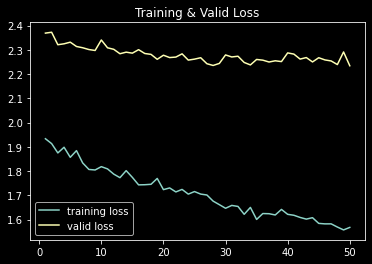

In [165]:
plot_loss(history)

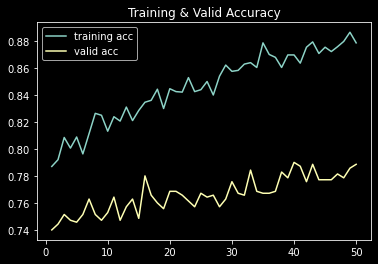

In [166]:
plot_acc(history)

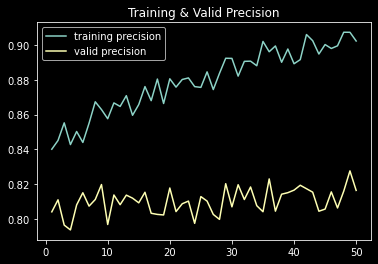

In [167]:
plot_precision(history)

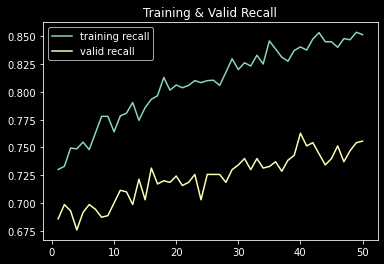

In [168]:
plot_recall(history)

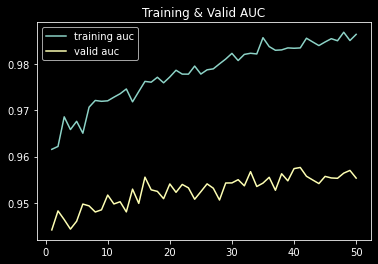

In [169]:
plot_auc(history)

## Evaluate model

In [170]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 690ms/step - loss: 1.8095 - categorical_accuracy: 0.7886 - precision: 0.8164 - recall: 0.7557 - auc: 0.9554


[1.809542883526195, 0.7885714, 0.81635803, 0.7557143, 0.9553686]

In [171]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [172]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 611ms/step


In [173]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.53      0.65      0.58        68
     moderate       0.74      0.65      0.69       184
       severe       0.39      0.40      0.39        35
proliferative       0.50      0.52      0.51        54

     accuracy                           0.79       700
    macro avg       0.62      0.64      0.63       700
 weighted avg       0.79      0.79      0.79       700



In [174]:
confusion_matrix(y_true, y_pred)

array([[347,   9,   3,   0,   0],
       [  8,  44,  13,   0,   3],
       [  9,  24, 119,  17,  15],
       [  0,   1,  10,  14,  10],
       [  1,   5,  15,   5,  28]], dtype=int64)

# Fine Tune N=9

In [175]:
del(model)

In [176]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [177]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [178]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_19 False
conv2d_846 False
batch_normalization_864 False
activation_864 False
conv2d_847 False
batch_normalization_865 False
activation_865 False
conv2d_848 False
batch_normalization_866 False
activation_866 False
max_pooling2d_36 False
conv2d_849 False
batch_normalization_867 False
activation_867 False
conv2d_850 False
batch_normalization_868 False
activation_868 False
max_pooling2d_37 False
conv2d_854 False
batch_normalization_872 False
activation_872 False
conv2d_852 False
conv2d_855 False
batch_normalization_870 False
batch_normalization_873 False
activation_870 False
activation_873 False
average_pooling2d_81 False
conv2d_851 False
conv2d_853 False
conv2d_856 False
conv2d_857 False
batch_normalization_869 False
batch_normalization_871 False
batch_normalization_874 False
batch_normalization_875 False
activation_869 False
activation_871 False
activation_874 False
activation_875 False
mixed0 False
conv2d_861 False
batch_normalization_879 False
activation_879 False
conv2d_859 Fals

In [179]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_9 (TensorFl [(None, 299, 299, 3) 0           input_20[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_9 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_9[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_9[0][0]          
____________________________________________________________________________________________

In [180]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 177s 2s/step - loss: 1.9238 - categorical_accuracy: 0.7752 - precision: 0.8322 - recall: 0.7287 - auc: 0.9603 - val_loss: 2.3507 - val_categorical_accuracy: 0.7429 - val_precision: 0.8081 - val_recall: 0.6857 - val_auc: 0.9467
Epoch 2/50
88/88 [==============================] - 142s 2s/step - loss: 1.9253 - categorical_accuracy: 0.7863 - precision: 0.8372 - recall: 0.7370 - auc: 0.9633 - val_loss: 2.3326 - val_categorical_accuracy: 0.7529 - val_precision: 0.8174 - val_recall: 0.6971 - val_auc: 0.9503
Epoch 3/50
88/88 [==============================] - 141s 2s/step - loss: 1.8743 - categorical_accuracy: 0.8041 - precision: 0.8478 - recall: 0.7527 - auc: 0.9665 - val_loss: 2.2962 - val_categorical_accuracy: 0.7386 - val_precision: 0.7887 - val_recall: 0.6771 - val_auc: 0.9423
Epoch 4/50
88/88 [==============================] - 142s 2s/step - loss

In [181]:
model.save(os.path.join(dir_save, "fine_tune-9_layer.h5"))

## Plot training result

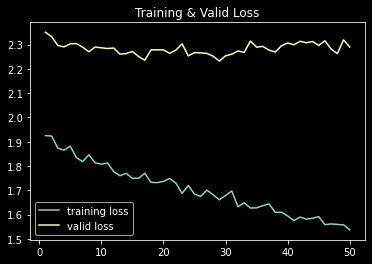

In [182]:
plot_loss(history)

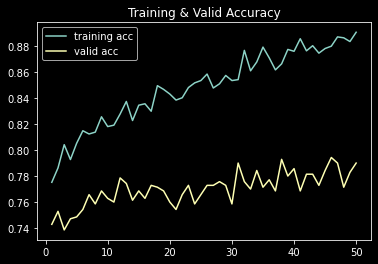

In [183]:
plot_acc(history)

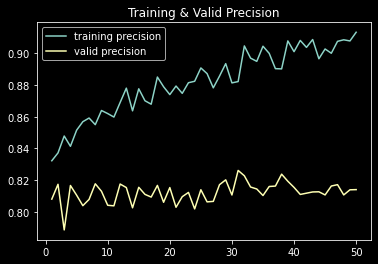

In [184]:
plot_precision(history)

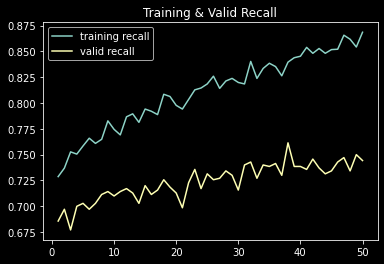

In [185]:
plot_recall(history)

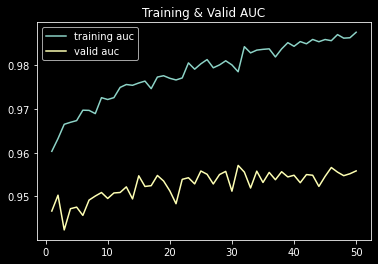

In [186]:
plot_auc(history)

## Evaluate model

In [187]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 652ms/step - loss: 1.8149 - categorical_accuracy: 0.7900 - precision: 0.8141 - recall: 0.7443 - auc: 0.9559


[1.8149146979505366, 0.79, 0.8140625, 0.7442857, 0.9558538]

In [188]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [189]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 602ms/step


In [190]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.56      0.53      0.55        68
     moderate       0.73      0.68      0.71       184
       severe       0.36      0.37      0.37        35
proliferative       0.47      0.54      0.50        54

     accuracy                           0.79       700
    macro avg       0.62      0.62      0.62       700
 weighted avg       0.79      0.79      0.79       700



In [191]:
confusion_matrix(y_true, y_pred)

array([[349,   6,   4,   0,   0],
       [  8,  36,  18,   0,   6],
       [  8,  15, 126,  18,  17],
       [  0,   1,  11,  13,  10],
       [  1,   6,  13,   5,  29]], dtype=int64)

# Fine Tune N=10

In [192]:
del(model)

In [193]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [194]:
# fine tuning n-layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed0":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [195]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_21 False
conv2d_940 False
batch_normalization_960 False
activation_960 False
conv2d_941 False
batch_normalization_961 False
activation_961 False
conv2d_942 False
batch_normalization_962 False
activation_962 False
max_pooling2d_40 False
conv2d_943 False
batch_normalization_963 False
activation_963 False
conv2d_944 False
batch_normalization_964 False
activation_964 False
max_pooling2d_41 False
conv2d_948 False
batch_normalization_968 False
activation_968 False
conv2d_946 False
conv2d_949 False
batch_normalization_966 False
batch_normalization_969 False
activation_966 False
activation_969 False
average_pooling2d_90 False
conv2d_945 False
conv2d_947 False
conv2d_950 False
conv2d_951 False
batch_normalization_965 False
batch_normalization_967 False
batch_normalization_970 False
batch_normalization_971 False
activation_965 False
activation_967 False
activation_970 False
activation_971 False
mixed0 True
conv2d_955 True
batch_normalization_975 True
activation_975 True
conv2d_953 True
con

In [196]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_10 (TensorF [(None, 299, 299, 3) 0           input_22[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_10 (TensorFlowO [(None, 299, 299, 3) 0           tf_op_layer_truediv_10[0][0]     
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_10[0][0]         
___________________________________________________________________________________________

In [197]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 196s 2s/step - loss: 1.9222 - categorical_accuracy: 0.7920 - precision: 0.8416 - recall: 0.7387 - auc: 0.9615 - val_loss: 2.3632 - val_categorical_accuracy: 0.7486 - val_precision: 0.8081 - val_recall: 0.6857 - val_auc: 0.9443
Epoch 2/50
88/88 [==============================] - 166s 2s/step - loss: 1.8828 - categorical_accuracy: 0.7959 - precision: 0.8383 - recall: 0.7466 - auc: 0.9654 - val_loss: 2.3748 - val_categorical_accuracy: 0.7543 - val_precision: 0.8079 - val_recall: 0.7029 - val_auc: 0.9480
Epoch 3/50
88/88 [==============================] - 168s 2s/step - loss: 1.9006 - categorical_accuracy: 0.8027 - precision: 0.8495 - recall: 0.7484 - auc: 0.9644 - val_loss: 2.3386 - val_categorical_accuracy: 0.7600 - val_precision: 0.8174 - val_recall: 0.7100 - val_auc: 0.9486
Epoch 4/50
88/88 [==============================] - 166s 2s/step - loss

In [198]:
model.save(os.path.join(dir_save, "fine_tune-10_layer.h5"))

## Plot training result

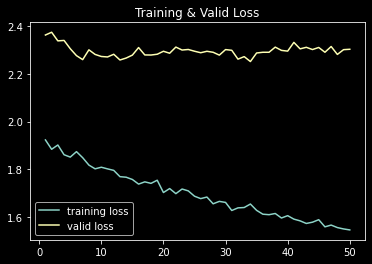

In [199]:
plot_loss(history)

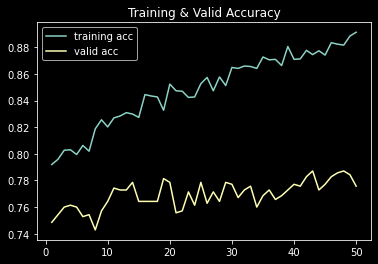

In [200]:
plot_acc(history)

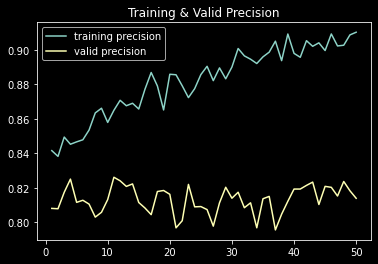

In [201]:
plot_precision(history)

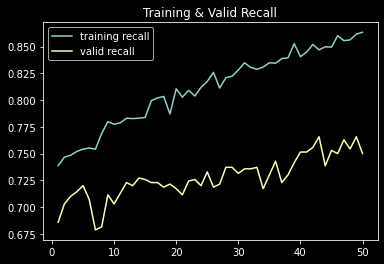

In [202]:
plot_recall(history)

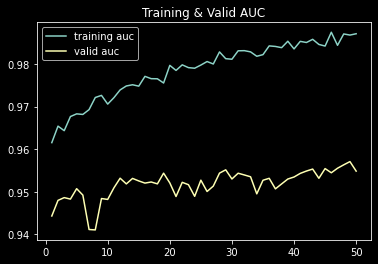

In [203]:
plot_auc(history)

## Evaluate model

In [204]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 690ms/step - loss: 1.8239 - categorical_accuracy: 0.7757 - precision: 0.8140 - recall: 0.7500 - auc: 0.9549


[1.8238989277319475, 0.7757143, 0.81395346, 0.75, 0.95485944]

In [205]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [206]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 634ms/step


In [207]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.98      0.96       359
         mild       0.54      0.51      0.53        68
     moderate       0.72      0.61      0.66       184
       severe       0.33      0.43      0.38        35
proliferative       0.46      0.54      0.50        54

     accuracy                           0.78       700
    macro avg       0.60      0.61      0.60       700
 weighted avg       0.78      0.78      0.78       700



In [208]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   2,   0,   0],
       [  9,  35,  17,   1,   6],
       [ 10,  18, 113,  24,  19],
       [  0,   1,  10,  15,   9],
       [  1,   5,  14,   5,  29]], dtype=int64)

# Fine Tune All Layer

In [209]:
del(model)

In [210]:
conv_base, model = create_model()
model.load_weights(os.path.join(dir_save, "EOE_classifier-20201212.h5"), by_name=False, skip_mismatch=False)

In [211]:
# fine tuning n-layers
conv_base.trainable = True

In [212]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_23 True
conv2d_1034 True
batch_normalization_1056 True
activation_1056 True
conv2d_1035 True
batch_normalization_1057 True
activation_1057 True
conv2d_1036 True
batch_normalization_1058 True
activation_1058 True
max_pooling2d_44 True
conv2d_1037 True
batch_normalization_1059 True
activation_1059 True
conv2d_1038 True
batch_normalization_1060 True
activation_1060 True
max_pooling2d_45 True
conv2d_1042 True
batch_normalization_1064 True
activation_1064 True
conv2d_1040 True
conv2d_1043 True
batch_normalization_1062 True
batch_normalization_1065 True
activation_1062 True
activation_1065 True
average_pooling2d_99 True
conv2d_1039 True
conv2d_1041 True
conv2d_1044 True
conv2d_1045 True
batch_normalization_1061 True
batch_normalization_1063 True
batch_normalization_1066 True
batch_normalization_1067 True
activation_1061 True
activation_1063 True
activation_1066 True
activation_1067 True
mixed0 True
conv2d_1049 True
batch_normalization_1071 True
activation_1071 True
conv2d_1047 True
con

In [213]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-6),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_11 (TensorF [(None, 299, 299, 3) 0           input_24[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_11 (TensorFlowO [(None, 299, 299, 3) 0           tf_op_layer_truediv_11[0][0]     
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_11[0][0]         
___________________________________________________________________________________________

In [214]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
88/88 [==============================] - 186s 2s/step - loss: 1.9578 - categorical_accuracy: 0.7823 - precision: 0.8400 - recall: 0.7334 - auc: 0.9597 - val_loss: 2.3556 - val_categorical_accuracy: 0.7214 - val_precision: 0.7774 - val_recall: 0.6586 - val_auc: 0.9382
Epoch 2/50
88/88 [==============================] - 148s 2s/step - loss: 1.9171 - categorical_accuracy: 0.7916 - precision: 0.8380 - recall: 0.7341 - auc: 0.9627 - val_loss: 2.3325 - val_categorical_accuracy: 0.7371 - val_precision: 0.7983 - val_recall: 0.6843 - val_auc: 0.9433
Epoch 3/50
88/88 [==============================] - 146s 2s/step - loss: 1.8983 - categorical_accuracy: 0.7970 - precision: 0.8441 - recall: 0.7395 - auc: 0.9639 - val_loss: 2.3480 - val_categorical_accuracy: 0.7457 - val_precision: 0.8057 - val_recall: 0.6871 - val_auc: 0.9472
Epoch 4/50
88/88 [==============================] - 146s 2s/step - loss

In [215]:
model.save(os.path.join(dir_save, "fine_tune-all_layer.h5"))

## Plot training result

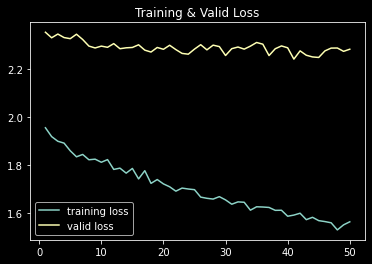

In [216]:
plot_loss(history)

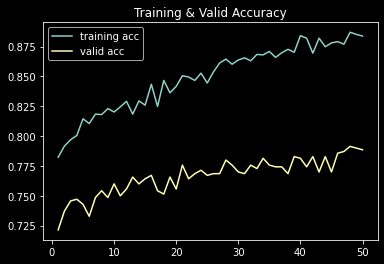

In [217]:
plot_acc(history)

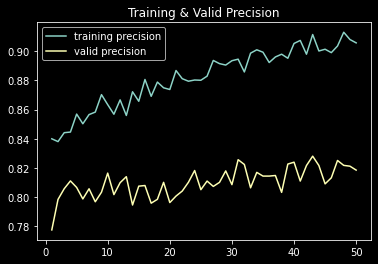

In [218]:
plot_precision(history)

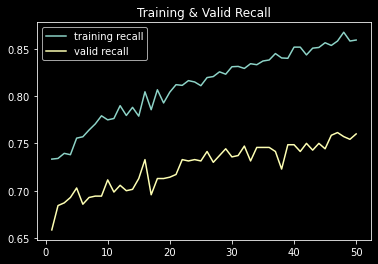

In [219]:
plot_recall(history)

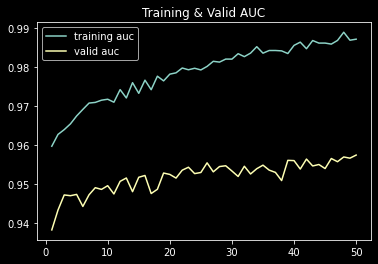

In [220]:
plot_auc(history)

## Evaluate model

In [221]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 682ms/step - loss: 1.8081 - categorical_accuracy: 0.7886 - precision: 0.8185 - recall: 0.7600 - auc: 0.9574


[1.8081201694228433, 0.7885714, 0.81846154, 0.76, 0.95740306]

In [222]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [223]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 623ms/step


In [224]:
print(classification_report(y_true, y_pred, target_names=[
      "normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.95      0.98      0.96       359
         mild       0.55      0.60      0.57        68
     moderate       0.73      0.64      0.68       184
       severe       0.36      0.46      0.40        35
proliferative       0.53      0.48      0.50        54

     accuracy                           0.79       700
    macro avg       0.62      0.63      0.62       700
 weighted avg       0.79      0.79      0.79       700



In [225]:
confusion_matrix(y_true, y_pred)

array([[351,   5,   3,   0,   0],
       [  8,  41,  15,   1,   3],
       [  9,  22, 118,  23,  12],
       [  0,   1,  10,  16,   8],
       [  1,   6,  16,   5,  26]], dtype=int64)